In [3]:
# import libraries
import odl
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import time

# set hyperparameters
batch_size = 128
learning_rate = 0.001
num_epochs = 5
data_root = './data'

# Radon Transform Settings
image_size = 28  # MNIST images are 28x28
num_angles = 30  # Number of projection angles
angle_partition = odl.uniform_partition(0, np.pi, num_angles)
detector_partition = odl.uniform_partition(-image_size // 2, image_size // 2, image_size)

space = odl.uniform_discr([-14, -14], [14, 14], (image_size, image_size), dtype='float32')
geometry = odl.tomo.Parallel2dGeometry(angle_partition, detector_partition)
ray_transform = odl.tomo.RayTransform(space, geometry)

# Function to apply Radon Transform
def apply_radon_transform(tensor):
    array = tensor.numpy().squeeze()  # Convert to NumPy, shape: [28, 28]
    sinogram = ray_transform(array).asarray()  # Apply Radon transform
    return torch.tensor(sinogram, dtype=torch.float32).unsqueeze(0)  # Add channel dim

# Preprocessing and MNIST loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

if not os.path.exists(data_root) or not os.listdir(data_root):
    train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=True)
    test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=True)
else:
    train_dataset = datasets.MNIST(root=data_root, train=True, transform=transform, download=False)
    test_dataset = datasets.MNIST(root=data_root, train=False, transform=transform, download=False)

# Apply Radon Transform to Dataset
class SinogramDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]
        sinogram = apply_radon_transform(image)  # Apply Radon transform
        return sinogram, label

train_dataset = SinogramDataset(train_dataset)
test_dataset = SinogramDataset(test_dataset)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define CNN model for sinogram data
class SinogramCNN(nn.Module):
    def __init__(self):
        super(SinogramCNN, self).__init__()
        # 1st convolution layer：输入通道为1（灰度图），输出通道为16，kernel size 3x3
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # pooling layer，size 2x2

        # 2nd convolution layer：输入通道16，输出通道为32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # fully connected layer
        self.fc1 = nn.Linear(32 * (num_angles // 4) * (detector_partition.size // 4), 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # output

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

# Define device, loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SinogramCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data, targets = data.to(device), targets.to(device)

        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Training time
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Testing
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = model(data)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch [1/5], Loss: 0.1114
Epoch [2/5], Loss: 0.1038
Epoch [3/5], Loss: 0.1539
Epoch [4/5], Loss: 0.0466
Epoch [5/5], Loss: 0.0125
Training Time: 192.26 seconds
Test Accuracy: 98.64%


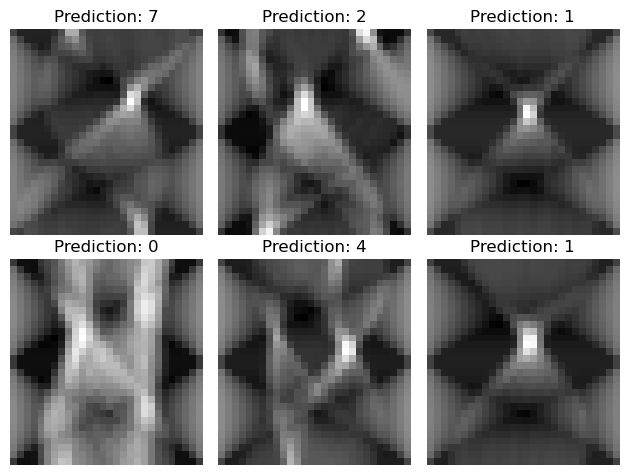

In [4]:
# Visualization
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data = example_data.to(device)

with torch.no_grad():
    outputs = model(example_data)
    _, predicted = outputs.max(1)
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(example_data[i][0].cpu(), cmap='gray')
    plt.title(f"Prediction: {predicted[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()